[易方达创业板ETF](https://finance.sina.com.cn/fund/quotes/159915/bc.shtml)

[深圳证券交易所](http://www.szse.cn/market/product/list/etfList/index.html)

https://finance.sina.com.cn/stock/stockzmt/2020-03-18/doc-iimxyqwa1302257.shtml

https://blog.csdn.net/qq_41648495/article/details/114380780

根据[循环回测](#%E5%BE%AA%E7%8E%AF%E5%9B%9E%E6%B5%8B)发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以产生较少的负向收益，甚至产生正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

每年浮动盈亏比较（以`399300`作为基准比较）：

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.888407 |                             1.04292 |                                  0.888407 |                      1.04292  |         27 |         22 |              10329   |              10345.5 |     -0.192823  |      -0.138827 |
| 2017-01-01~2017-12-31 |                                        2.10474  |                             1.96406 |                                  1.21633  |                      0.921143 |         41 |         33 |               9172.8 |               9206.4 |     -0.0626738 |      -0.142027 |
| 2018-01-01~2018-12-31 |                                        2.84899  |                             2.84984 |                                  0.744251 |                      0.885771 |         40 |         37 |                  0   |                  0   |     -0.316742  |      -0.217943 |
| 2019-01-01~2019-12-31 |                                        4.20679  |                             4.10578 |                                  1.3578   |                      1.25594  |         25 |         19 |                  0   |                  0   |     -0.131147  |      -0.115312 |
| 2020-01-01~2020-12-31 |                                        5.47125  |                             5.70559 |                                  1.26446  |                      1.59982  |         57 |         29 |              15394.5 |              15763   |     -0.162244  |      -0.109    |

（以`159915`作为基准比较）

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.743185 |                             1.04292 |                                  0.743185 |                      1.04292  |         27 |         22 |              10329   |              10345.5 |      -0.235353 |      -0.138827 |
| 2017-01-01~2017-12-31 |                                        1.61672  |                             1.96406 |                                  0.873539 |                      0.921143 |         41 |         33 |               9172.8 |               9206.4 |      -0.177495 |      -0.142027 |
| 2018-01-01~2018-12-31 |                                        2.34036  |                             2.84984 |                                  0.723636 |                      0.885771 |         40 |         37 |                  0   |                  0   |      -0.356348 |      -0.217943 |
| 2019-01-01~2019-12-31 |                                        3.78443  |                             4.10578 |                                  1.44407  |                      1.25594  |         25 |         19 |                  0   |                  0   |      -0.198336 |      -0.115312 |
| 2020-01-01~2020-12-31 |                                        5.42872  |                             5.70559 |                                  1.64429  |                      1.59982  |         57 |         29 |              15394.5 |              15763   |      -0.197064 |      -0.109    |

In [1]:
# import logging
# logging.basicConfig(level=logging.DEBUG) 

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt

you are using non-interactive mdoel quantaxis


### 原始数据

In [32]:
CODE='159915'
START='2011-09-20'
END='2019-12-31'
INIT_CASH=10000
DEFAULT_MA=20

In [33]:
def get_data(code,start,end,ma=DEFAULT_MA):
    ori_data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    data_qfq = ori_data
    # 收盘价变化率
    data_qfq['pct'] = data_qfq['close'].pct_change()
    data_qfq['date'] = data_qfq.index.get_level_values(0)
    data_qfq['date'] = pd.to_datetime(data_qfq['date'])
    # 星期一为0，星期天为6
    data_qfq['weekday'] = data_qfq['date'].dt.weekday
    data_qfq['nextday']=data_qfq['weekday'].shift(-1)
    # 简单移动均线
    data_qfq["MA"] = QA.QA_indicator_MA(data_qfq, ma)
    data_qfq['avg_price']=(data_qfq['close']+data_qfq['open']+data_qfq['high']+data_qfq['low'])/4
    data_qfq['avg_pct'] = data_qfq['avg_price'].pct_change()
    data_qfq['up']=False
    data_qfq['down']=False
    data_qfq.loc[data_qfq['close']>data_qfq["MA"],'up']=True
    data_qfq.loc[data_qfq['close']<data_qfq["MA"],'down']=True
    data_qfq['prev_up']=data_qfq['up'].shift()
    data_qfq['prev_down']=data_qfq['down'].shift()

    data_qfq.dropna(inplace=True)
    return data_qfq

In [34]:
data_qfq=get_data(CODE,START,END)
data_qfq.head(1)

,open,close,high,low,vol,amount,date_stamp,volume,pct,date,weekday,nextday,MA,avg_price,avg_pct,up,down,prev_up,prev_down
date,,,,,,,,,,,,,,,,,,,
2012-01-09,0.667,0.696,0.698,0.658,1778470.0,1.2114e+08,1.3260e+09,1778470.0,0.0388,2012-01-09,0,1.0,0.7451,0.6797,0.0218,False,True,False,False


In [35]:
def get_desc(data,**kwargs):
    data['change']=(data['close']-data['open'])/data['close']
    pct=data.groupby('weekday')['pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '收盘价涨跌幅均值',
        'median': '收盘价涨跌幅中位数'
    })
    pct1=data.groupby('weekday')['avg_pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日均值涨跌幅均值',
        'median': '日均值涨跌幅中位数'
    })
    pct2=data.groupby('weekday')['change'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日收盘相对开盘涨跌幅均值',
        'median': '日收盘相对开盘涨跌幅中位数'
    })
    # 胜率
    temp1 = data.groupby('weekday')['pct'].size()
    temp2 = data[data['pct'] > 0].groupby(
    'weekday')['pct'].size()
    win_rate=(temp2 / temp1).to_frame('收盘价涨跌幅胜率').sort_values(
    '收盘价涨跌幅胜率', ascending=False)
    
    df=pct.join(win_rate).join(pct1).join(pct2).sort_index()
    df.set_index(pd.Index(['周一','周二','周三','周四','周五']),inplace=True)
    return df

def show_desc(data,info_only=True,**kwargs):
    df=get_desc(data,**kwargs)
    if not info_only:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(131)
        ax2 = f.add_subplot(132)
        ax3 = f.add_subplot(133)

        ax1.plot(df.index, df[['收盘价涨跌幅均值','收盘价涨跌幅中位数']])
        ax1.legend(['均值','中位数'])
        ax1.set_title("收盘价涨跌幅")

        ax2.plot(df.index, df[['日均值涨跌幅均值','日均值涨跌幅中位数']])
        ax2.legend(['均值','中位数'])
        ax2.set_title("日均值涨跌幅")

        ax3.plot(df.index, df[['日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数']])
        ax3.legend(['均值','中位数'])
        ax3.set_title("日均值涨跌幅")
        
        plot_title=kwargs.pop('plot_title',"")
        f.suptitle(plot_title)
    
    return df.T.style.highlight_max(color='red', axis=1).highlight_min(
        color='green', axis=1).format("{:.2%}")

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.29%,0.09%,-0.06%,-0.16%,0.00%
收盘价涨跌幅均值,0.18%,0.18%,0.02%,-0.15%,0.14%
收盘价涨跌幅胜率,54.59%,51.15%,47.72%,45.13%,49.35%
日均值涨跌幅中位数,0.08%,0.22%,0.11%,-0.04%,-0.03%
日均值涨跌幅均值,0.12%,0.09%,0.15%,-0.04%,-0.01%
日收盘相对开盘涨跌幅中位数,0.37%,0.21%,0.07%,0.00%,0.14%
日收盘相对开盘涨跌幅均值,0.22%,0.35%,0.12%,-0.02%,0.20%


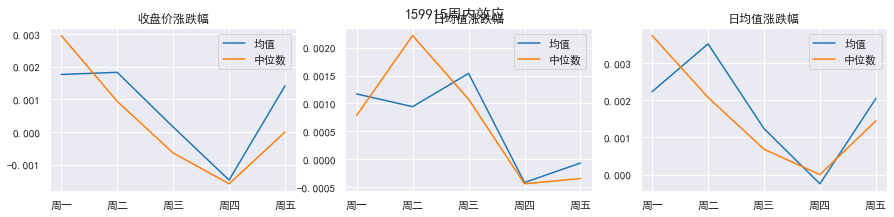

In [36]:
show_desc(data_qfq,False,plot_title='{}周内效应'.format(CODE))

In [37]:
def simple_test(data,plot=True,**kwargs):
    """
    **未考虑T+1交易的情况**
    Args:
        trade_func: 交易方法。用来在data中标记buy和sell。默认为None。
        plot_title: 绘图时的标题
    """
    dt=data.copy()
    dt['buy']=0
    dt['sell']=0
    trade_func=kwargs.pop('trade_func',None)
    trade_func_params=kwargs.pop('trade_func_params',{})
    if trade_func:
        trade_func(dt,**trade_func_params)
    dt['每日均价变更']=dt['avg_price'].pct_change()
    dt['每日开盘/收盘变更']=dt['close']/dt['open']-1
    dt['每日收盘价变更']=dt['close'].pct_change()
    # 持仓标记
    dt['hold']=dt['buy'].replace(0, np.NaN).fillna(method='ffill')
    dt.loc[(dt['hold']==1)&(dt['sell']==1),'hold']=np.NaN
    dt['hold'].fillna(0,inplace=True)
    #考虑A股T+1特性，去除前后hold均为0但当天hold为1的数据
    dt['hold_real']=dt['hold']
    dt.loc[(dt['hold_real']==1)&(dt['hold_real'].shift()==0)&(dt['hold_real'].shift(-1)==0),'hold_real']=0
    dt['策略-每日均价累加']=(dt['每日均价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日均价累加']=(dt['每日均价变更']*dt['hold_real']).cumsum()
    dt['基准-每日均价累加']=(dt['每日均价变更']).cumsum()
    dt['策略-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold_real']).cumsum()
    dt['基准-每日收盘价累加']=(dt['每日收盘价变更']).cumsum()
    if plot:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(dt.index,dt['策略-每日均价累加'],label='策略')
        ax1.plot(dt.index,dt['策略T+1-每日均价累加'],label='策略T+1')
        ax1.plot(dt.index,dt['基准-每日均价累加'],label='基准')
        ax1.legend()
        ax1.set_title("每日均价变更")
        ax2.plot(dt.index,dt['策略-每日收盘价累加'],label='策略')
        ax2.plot(dt.index,dt['策略T+1-每日收盘价累加'],label='策略T+1')
        ax2.plot(dt.index,dt['基准-每日收盘价累加'],label='基准')
        ax2.legend()
        ax2.set_title("每日收盘价变更")
    return dt

以`收盘价涨跌幅胜率`来看，应该跳过周三、周四和周五三天。

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周二(1)|开盘价(open)|
|周二(1)|周一(0)、周二(1)|开盘价(open)|
|周三(2)|周一(0)、周二(1)|开盘价(open)|
|周四(3)|周一(0)、周二(1)|收盘价(close)|
|周五(4)|周一(0)、周二(1)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)、周五(4)|收盘价(close)|
|周二(1)|周三(2)、周四(3)、周五(4)|收盘价(close)|
|周三(2)|周三(2)、周四(3)、周五(4)|收盘价(close)|
|周四(3)|周三(2)、周四(3)、周五(4)|开盘价(open)|
|周五(4)|周三(2)、周四(3)、周五(4)|收盘价(close)|

In [38]:
def simple_trade_func(data,**kwargs):
    data.loc[(data['nextday'].isin([0,1])),'buy']=1
    
    data.loc[~(data['weekday'].isin([0,1])),'sell']=1
    return data

# simple_data=simple_test(get_data(CODE,START,END),trade_func=simple_trade_func)

回归测试

实际操作过程中，竟然**大幅跑赢基准**，有点不可思议。

In [39]:
def simple_buy_price_func(index, row, data):
    tom = data.iloc[data.index.get_loc(index)+1]
    if row['weekday'] in (0,1,2,4):
        return row['open']
    else:
        return row['close']

def simple_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,2,4):
        return row['close']
    else:
        return row['open']

from gquant.backtest import backtest
x = get_data(CODE, START, END)
y = get_data('399300', START, END)#以399300作为基准比较
simple_trade_func(x)
m = backtest(x, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1941it [00:02, 911.18it/s] 


基准收益                           0.6142
策略收益                           4.1448
基准年化收益                         0.0770
策略年化收益                         0.5197
基准最大回撤                        -0.4669
策略最大回撤                        -0.6142
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.6216
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    5.5326
dtype: float64

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                        61.7001
交易次数                       392.0000
未结束交易次数                      1.0000
未结束交易购买金额                55296.0000
未结束交易当前价值                55264.0000
盈利次数                       223.0000
亏损次数                       166.0000
盈利次数占比                       0.5689
盈利(含交易费)次数                 222.0000
亏损(含交易费)次数                 169.0000
盈利(含交易费)次数占比                 0.5663
盈利交易平均获利                  1221.3587
亏损交易平均亏损                 -1312.3367
盈利(含交易费)交易平均获利            1226.7468
亏损(含交易费)交易平均亏损           -1288.8917
盈亏总额                     54515.1000
手续费总额                     9157.3999
手续费均值                       11.6953
最大盈利%                        0.1485
最大亏损%                       -0.2526
最大(含交易费)盈利%                  0.1478
最大(含交易费)亏损%                 -0.2531
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.6216
结算价值(未结束交易当前价值+剩余现金)     55325.7001
浮动盈亏(结算价值/初始资金)              5.5326
dtype: float64


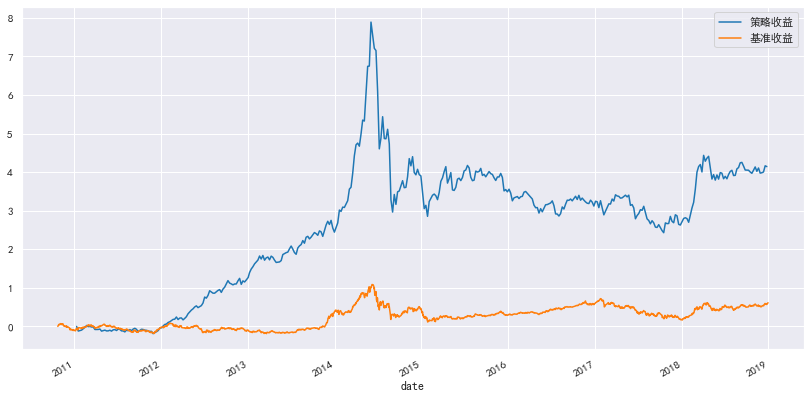

In [41]:
m.plot_cash()

下面考虑估计在上涨市（前日收盘价高于20日均线）、下跌市（前日收盘价低于20日均线）的市场中是否存在可以被利用的周内效应。

# 上涨市

In [42]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_up']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.45%,-0.06%,-0.06%,-0.17%,-0.07%
收盘价涨跌幅均值,0.38%,0.05%,0.04%,-0.17%,0.08%
收盘价涨跌幅胜率,57.21%,46.89%,47.17%,45.05%,47.09%
日均值涨跌幅中位数,0.30%,0.40%,0.17%,0.02%,0.04%
日均值涨跌幅均值,0.43%,0.49%,0.29%,0.15%,0.16%
日收盘相对开盘涨跌幅中位数,0.46%,0.09%,0.07%,-0.05%,0.14%
日收盘相对开盘涨跌幅均值,0.48%,0.16%,0.13%,-0.09%,0.15%


以`收盘价涨跌幅胜率`来看，应该只在周一持有股票

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)|开盘价(open)|
|周二(1)|周一(0)|开盘价(open)|
|周三(2)|周一(0)|开盘价(open)|
|周四(3)|周一(0)|收盘价(close)|
|周五(4)|周一(0)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周二(1)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周三(2)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周四(3)|周二(1)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周五(4)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|

In [43]:
def _rasing_trade_fun_buy(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0])),'buy']=1
    return data

def _rasing_trade_fun_sell(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([1,2,3,4])),'sell']=1
    return data

def rasing_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data.loc[data.shift()['up']!=True,'sell']=1
    return data

def rasing_buy_price_func(index, row, data):
    if row['weekday'] in (0,1,2,4):
        return row['open']
    else:
        return row['close']

def rasing_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,2,4):
        return row['close']
    else:
        return row['open']

x = get_data(CODE, START, END)
y = get_data('399300', START, END)
rasing_trade_func_fix(x)
m = backtest(x, benchmark_pd=y[y['prev_up']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=rasing_buy_price_func, sell_price_func=rasing_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1941it [00:01, 1867.91it/s]


基准收益                           0.5433
策略收益                           0.9550
基准年化收益                         0.1224
策略年化收益                         0.2151
基准最大回撤                        -0.4552
策略最大回撤                        -0.3657
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.5619
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    2.0020
dtype: float64

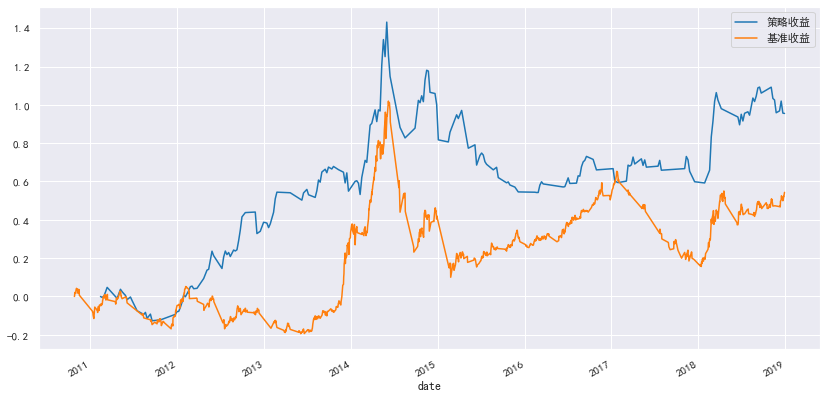

In [44]:
m.plot_cash()

# 下跌市

In [45]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_down']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.11%,0.30%,-0.07%,-0.12%,0.12%
收盘价涨跌幅均值,-0.09%,0.33%,-0.01%,-0.12%,0.21%
收盘价涨跌幅胜率,51.16%,56.04%,48.35%,45.24%,51.96%
日均值涨跌幅中位数,-0.37%,-0.05%,0.02%,-0.19%,-0.22%
日均值涨跌幅均值,-0.27%,-0.36%,-0.00%,-0.30%,-0.20%
日收盘相对开盘涨跌幅中位数,0.24%,0.41%,0.07%,0.08%,0.14%
日收盘相对开盘涨跌幅均值,-0.12%,0.57%,0.11%,0.06%,0.27%


以`收盘价涨跌幅胜率`来看，应该只在周一、周二和周五持有股票。*周一要不要，还有待考虑*

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周二(1)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周四(3)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周五(4)|周一(0)、周二(1)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)|开盘价(open)|
|周二(1)|周三(2)、周四(3)|收盘价(close)|
|周三(2)|周三(2)、周四(3)|收盘价(close)|
|周四(3)|周三(2)、周四(3)|收盘价(close)|
|周五(4)|周三(2)、周四(3)|收盘价(close)|

In [46]:
def _falling_trade_func_buy(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([0,1,4])),'buy']=1
    return data

def _falling_trade_func_sell(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([2,3])),'sell']=1
    return data

def falling_trade_func(data,**kwargs):
    data=_falling_trade_func_buy(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    data.loc[data.shift()['down']!=True,'sell']=1
    return data

def falling_buy_price_func(index, row, data):
    if row['weekday'] in (1,2,3,4):
        return row['open']
    else:
        return row['close']

def falling_sell_price_func(index, row, data):
    if row['weekday'] in (1,2,3,4):
        return row['close']
    else:
        return row['open']

x = get_data(CODE, START, END)
y = get_data('399300', START, END)
falling_trade_func(x)
m = backtest(x, benchmark_pd=y[y['prev_down']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=falling_buy_price_func, sell_price_func=falling_sell_price_func)
m.stats()

1941it [00:01, 1773.80it/s]


基准收益                           0.5105
策略收益                           0.9597
基准年化收益                         0.1445
策略年化收益                         0.2717
基准最大回撤                        -0.4435
策略最大回撤                        -0.3410
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.5168
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.8387
dtype: float64

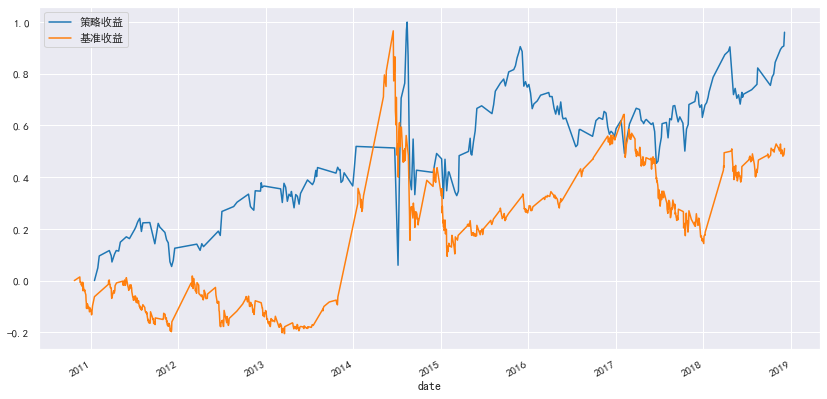

In [47]:
m.plot_cash()

---

# 合并上涨市和下跌市的买卖规则及买卖手法

In [48]:
def combine_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_falling_trade_func_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    return data

def combine_buy_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_buy_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_buy_price_func(index,row,data)

def combine_sell_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_sell_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_sell_price_func(index,row,data)


x = get_data(CODE, START, END)
y = get_data('399300', START, END)
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1941it [00:01, 1174.16it/s]


基准收益                           0.6142
策略收益                           3.9249
基准年化收益                         0.0770
策略年化收益                         0.4921
基准最大回撤                        -0.4669
策略最大回撤                        -0.3838
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.6216
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    4.5930
dtype: float64

😲  奇迹出现了！！！合并了上涨市和下跌市两种条件及购买卖出操作后，竟然**收益达到了基准的好几倍**。

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                     45930.4073
交易次数                       393.0000
未结束交易次数                      0.0000
未结束交易购买金额                    0.0000
未结束交易当前价值                    0.0000
盈利次数                       221.0000
亏损次数                       170.0000
盈利次数占比                       0.5623
盈利(含交易费)次数                 220.0000
亏损(含交易费)次数                 173.0000
盈利(含交易费)次数占比                 0.5598
盈利交易平均获利                   817.7819
亏损交易平均亏损                  -814.8635
盈利(含交易费)交易平均获利             821.4250
亏损(含交易费)交易平均亏损            -800.6387
盈亏总额                     42203.0000
手续费总额                     6272.5927
手续费均值                        7.9804
最大盈利%                        0.3977
最大亏损%                       -0.2534
最大(含交易费)盈利%                  0.3970
最大(含交易费)亏损%                 -0.2539
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.6216
结算价值(未结束交易当前价值+剩余现金)     45930.4073
浮动盈亏(结算价值/初始资金)              4.5930
dtype: float64


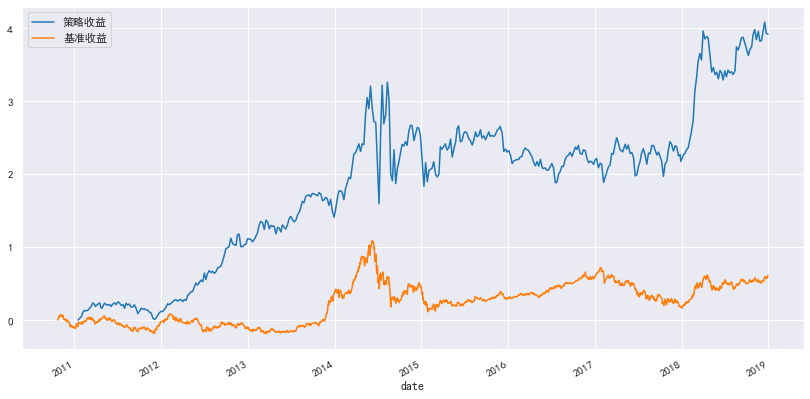

In [50]:
m.plot_cash()

---

# 盲测

In [52]:
x = get_data(CODE, '2001-12-01', '2021-12-31')
y = get_data('399300', '2001-12-01', '2021-12-31')

x = x['2020-01-01':'2020-12-31'].copy()
y = y['2020-01-01':'2020-12-31'].copy()
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()

243it [00:00, 1166.56it/s]


基准收益                           0.2459
策略收益                           0.4256
基准年化收益                         0.2530
策略年化收益                         0.4379
基准最大回撤                        -0.1622
策略最大回撤                        -0.1499
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.2645
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.4438
dtype: float64

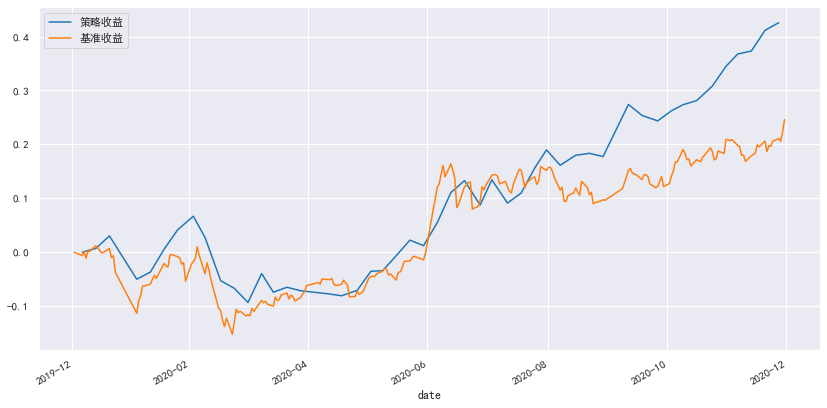

In [53]:
m.plot_cash()

In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                       108.2220
交易次数                        50.0000
未结束交易次数                      1.0000
未结束交易购买金额                14330.0000
未结束交易当前价值                14330.0000
盈利次数                        33.0000
亏损次数                        16.0000
盈利次数占比                       0.6600
盈利(含交易费)次数                  33.0000
亏损(含交易费)次数                  16.0000
盈利(含交易费)次数占比                 0.6600
盈利交易平均获利                   280.1333
亏损交易平均亏损                  -279.9125
盈利(含交易费)交易平均获利             280.1333
亏损(含交易费)交易平均亏损            -279.9125
盈亏总额                      4765.8000
手续费总额                      327.5780
手续费均值                        3.3089
最大盈利%                        0.0827
最大亏损%                       -0.0783
最大(含交易费)盈利%                  0.0821
最大(含交易费)亏损%                 -0.0788
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.2645
结算价值(未结束交易当前价值+剩余现金)     14438.2220
浮动盈亏(结算价值/初始资金)              1.4438
dtype: float64


Text(0.5, 1.0, '下跌市-日收盘相对开盘涨跌幅中位数')

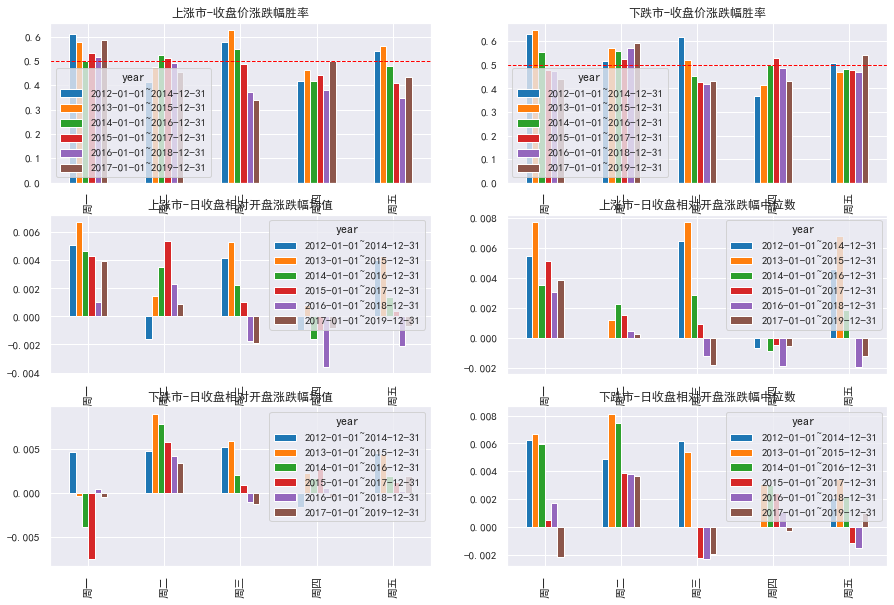

In [55]:
dfs_up=[]
dfs_down=[]
for i in range(2012,2018):
    start='{}-01-01'.format(i)
    end='{}-12-31'.format(i+2)
    data=get_data(CODE,start,end)
    df_up=get_desc(data[data['prev_up']==True]).T
    df_up['year']='{}~{}'.format(start,end)
    df_down=get_desc(data[data['prev_down']==True]).T
    df_down['year']='{}~{}'.format(start,end)
    dfs_up.append(df_up)
    dfs_down.append(df_down)
    
dfs_up=pd.concat(dfs_up)
dfs_down=pd.concat(dfs_down)

f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

# 日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数

dfs_up.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax1)
ax1.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax1.set_title("上涨市-收盘价涨跌幅胜率")
dfs_down.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax2)
ax2.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax2.set_title("下跌市-收盘价涨跌幅胜率")
dfs_up.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax3)
ax3.set_title("上涨市-日收盘相对开盘涨跌幅均值")
dfs_up.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax4)
ax4.set_title("上涨市-日收盘相对开盘涨跌幅中位数")
dfs_down.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax5)
ax5.set_title("下跌市-日收盘相对开盘涨跌幅均值")
dfs_down.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax6)
ax6.set_title("下跌市-日收盘相对开盘涨跌幅中位数")

从上图看来不同时间段周内效应会有一定的变化，其中周三的胜率逐步下降非常明显。

---

# 循环回测

分别简单根据上图测试了自2015年至2020年的每年数据。发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以产生较少的负向收益，甚至产生正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

---

以`399300`作为基准比较

In [58]:
def buy_2015(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 2, 4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        return row['open']


def sell_2015(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 2, 4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        return row['close']


def buy_2016(index, row, data):
    return row['open']


def sell_2016(index, row, data):
    return row['close']


def buy_2017(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2, 4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        return row['open']


def sell_2017(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2, 4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        return row['close']


def buy_2018(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2, 4):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3):
            return row['open']
        else:
            return row['close']
        
def sell_2018(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2, 4):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3):
            return row['close']
        else:
            return row['open']


def buy_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3):
            return row['open']
        else:
            return row['close']


def sell_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (0, 1, 3):
            return row['close']
        else:
            return row['open']


def buy_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 4):
            return row['open']
        else:
            return row['close']


def sell_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 4):
            return row['close']
        else:
            return row['open']


x = get_data(CODE, '2001-12-01', '2021-12-31')
y = get_data('399300', '2001-12-01', '2021-12-31')

x15 = x['2015-01-01':'2015-12-31'].copy()
y15 = y['2015-01-01':'2015-12-31'].copy()
x15.loc[(x15['prev_up'] == True) & (x15['nextday'].isin([0,2,4])), 'buy'] = 1
x15.loc[(x15['prev_down'] == True) & (x15['nextday'].isin([0, 1, 2,4])), 'buy'] = 1
x15.loc[(x15['prev_up'] == True) & (~x15['nextday'].isin([0,2,4])), 'sell'] = 1
x15.loc[(x15['prev_down'] == True) & (~x15['nextday'].isin([0, 1, 2,4])),
       'sell'] = 1

x16 = x['2016-01-01':'2016-12-31'].copy()
y16 = y['2016-01-01':'2016-12-31'].copy()
x16.loc[(x16['prev_up'] == True) & (x16['nextday'].isin([1, 2])), 'buy'] = 1
x16.loc[(x16['prev_down'] == True) & (x16['nextday'].isin([0, 1, 2])), 'buy'] = 1
x16.loc[(x16['prev_up'] == True) & (~x16['nextday'].isin([1, 2])), 'sell'] = 1
x16.loc[(x16['prev_down'] == True) & (~x16['nextday'].isin([0, 1, 2])),
       'sell'] = 1

x17 = x['2017-01-01':'2017-12-31'].copy()
y17 = y['2017-01-01':'2017-12-31'].copy()
x17.loc[(x17['prev_up'] == True) & (x17['nextday'].isin([1, 2])), 'buy'] = 1
x17.loc[(x17['prev_down'] == True) & (x17['nextday'].isin([0, 1, 3])), 'buy'] = 1
x17.loc[(x17['prev_up'] == True) & (~x17['nextday'].isin([1, 2])), 'sell'] = 1
x17.loc[(x17['prev_down'] == True) & (~x17['nextday'].isin([0, 1, 3])),
       'sell'] = 1

x18 = x['2018-01-01':'2018-12-31'].copy()
y18 = y['2018-01-01':'2018-12-31'].copy()
x18.loc[(x18['prev_up'] == True) & (x18['nextday'].isin([0, 1])), 'buy'] = 1
x18.loc[(x18['prev_down'] == True) & (x18['nextday'].isin([1, 3])), 'buy'] = 1
x18.loc[(x18['prev_up'] == True) & (~x18['nextday'].isin([0, 1])), 'sell'] = 1
x18.loc[(x18['prev_down'] == True) & (~x18['nextday'].isin([1, 3])), 'sell'] = 1

x19 = x['2019-01-01':'2019-12-31'].copy()
y19 = y['2019-01-01':'2019-12-31'].copy()
x19.loc[(x19['prev_up'] == True) & (x19['nextday'].isin([0])), 'buy'] = 1
x19.loc[(x19['prev_down'] == True) & (x19['nextday'].isin([1])), 'buy'] = 1
x19.loc[(x19['prev_up'] == True) & (~x19['nextday'].isin([0])), 'sell'] = 1
x19.loc[(x19['prev_down'] == True) & (~x19['nextday'].isin([1])), 'sell'] = 1

x20 = x['2020-01-01':'2020-12-31'].copy()
y20 = y['2020-01-01':'2020-12-31'].copy()
x20.loc[(x20['prev_up'] == True) & (x20['nextday'].isin([0, 3])), 'buy'] = 1
x20.loc[(x20['prev_down'] == True) & (x20['nextday'].isin([1, 4])), 'buy'] = 1
x20.loc[(x20['prev_up'] == True) & (~x20['nextday'].isin([0, 3])), 'sell'] = 1
x20.loc[(x20['prev_down'] == True) & (~x20['nextday'].isin([1, 4])), 'sell'] = 1

d={}
d['2016-01-01~2016-12-31']=backtest(x16,
             benchmark_pd=y16,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2016,
             sell_price_func=sell_2016)
d['2017-01-01~2017-12-31']=backtest(x17,
             benchmark_pd=y17,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2017,
             sell_price_func=sell_2017)
d['2018-01-01~2018-12-31']=backtest(x18,
             benchmark_pd=y18,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2018,
             sell_price_func=sell_2018)
d['2019-01-01~2019-12-31']=backtest(x19,
             benchmark_pd=y19,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2019,
             sell_price_func=sell_2019)
d['2020-01-01~2020-12-31']=backtest(x20,
             benchmark_pd=y20,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2020,
             sell_price_func=sell_2020)

every_year_stats = pd.DataFrame({k:v.stats() for k,v in d.items()}).T
every_year_reports = pd.DataFrame({k:v.report() for k,v in d.items()}).T

244it [00:00, 1200.07it/s]
244it [00:00, 849.30it/s]
243it [00:00, 822.79it/s]
244it [00:00, 1270.27it/s]
243it [00:00, 724.93it/s]


In [59]:
every_year_stats.sort_index()[['基准收益','策略收益']]

,基准收益,策略收益
2016-01-01~2016-12-31,-0.0426,0.1360
2017-01-01~2017-12-31,0.2104,-0.0887
2018-01-01~2018-12-31,-0.2615,-0.1128
2019-01-01~2019-12-31,0.3881,0.2444
2020-01-01~2020-12-31,0.2459,0.5469


In [60]:
print(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)']].cumsum().join(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)','盈利次数','亏损次数','未结束交易购买金额','未结束交易当前价值']],lsuffix='cumsum').join(every_year_stats.sort_index()[['基准最大回撤','策略最大回撤']]).to_markdown())

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.888407 |                             1.04292 |                                  0.888407 |                      1.04292  |         27 |         22 |              10329   |              10345.5 |     -0.192823  |      -0.138827 |
| 2017-01-01~2017-12-31 |                                        2.10474  |                             1.96406 |                                  1.21633  |                      0.921143 |         41 |        

In [61]:
print(every_year_stats.sort_index()[['基准收益','策略收益']].cumsum().join(every_year_stats.sort_index()[['基准收益','策略收益','基准最大回撤','策略最大回撤']],lsuffix='cumsum').to_markdown())

|                       |   基准收益cumsum |   策略收益cumsum |   基准收益 |   策略收益 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|-----------------:|-----------------:|-----------:|-----------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |       -0.0426416 |        0.135954  | -0.0426416 |  0.135954  |     -0.192823  |      -0.138827 |
| 2017-01-01~2017-12-31 |        0.167807  |        0.047239  |  0.210448  | -0.0887152 |     -0.0626738 |      -0.142027 |
| 2018-01-01~2018-12-31 |       -0.0937246 |       -0.0655213 | -0.261531  | -0.11276   |     -0.316742  |      -0.217943 |
| 2019-01-01~2019-12-31 |        0.294384  |        0.178831  |  0.388109  |  0.244353  |     -0.131147  |      -0.115312 |
| 2020-01-01~2020-12-31 |        0.540324  |        0.725769  |  0.245939  |  0.546937  |     -0.162244  |      -0.109    |


---

与159915比较

---

In [62]:
d={}
d['2016-01-01~2016-12-31']=backtest(x16,
             benchmark_pd=x16,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2016,
             sell_price_func=sell_2016)
d['2017-01-01~2017-12-31']=backtest(x17,
             benchmark_pd=x17,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2017,
             sell_price_func=sell_2017)
d['2018-01-01~2018-12-31']=backtest(x18,
             benchmark_pd=x18,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2018,
             sell_price_func=sell_2018)
d['2019-01-01~2019-12-31']=backtest(x19,
             benchmark_pd=x19,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2019,
             sell_price_func=sell_2019)
d['2020-01-01~2020-12-31']=backtest(x20,
             benchmark_pd=x20,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2020,
             sell_price_func=sell_2020)

every_year_stats = pd.DataFrame({k:v.stats() for k,v in d.items()}).T
every_year_reports = pd.DataFrame({k:v.report() for k,v in d.items()}).T

print(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)']].cumsum().join(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)','盈利次数','亏损次数','未结束交易购买金额','未结束交易当前价值']],lsuffix='cumsum').join(every_year_stats.sort_index()[['基准最大回撤','策略最大回撤']]).to_markdown())

244it [00:00, 1170.43it/s]
244it [00:00, 839.62it/s]
243it [00:00, 824.95it/s]
244it [00:00, 1284.39it/s]
243it [00:00, 722.96it/s]


|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2016-01-01~2016-12-31 |                                        0.743185 |                             1.04292 |                                  0.743185 |                      1.04292  |         27 |         22 |              10329   |              10345.5 |      -0.235353 |      -0.138827 |
| 2017-01-01~2017-12-31 |                                        1.61672  |                             1.96406 |                                  0.873539 |                      0.921143 |         41 |        